<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/DCGAN_intro_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [0]:
train_images.dtype, train_images.shape

(dtype('uint8'), (50000, 32, 32, 3))

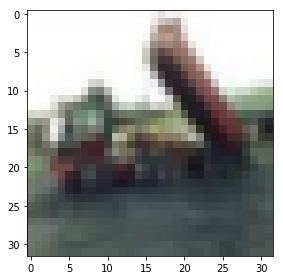

In [0]:
imshow(train_images[2])

In [0]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

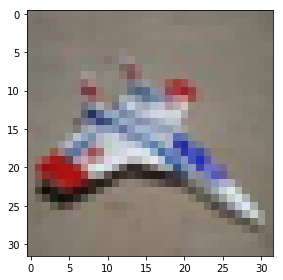

In [0]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[30]))

In [0]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((4, 4, 256)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
]
)

In [0]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32,32, 3)),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Flatten(),
   Dense(1)]
)

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 latent_dim])

In [0]:
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
      return gen_loss, disc_loss

In [0]:
train_step = tf.contrib.eager.defun(train_step)

W0825 11:28:56.324977 140078092625792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0825 11:28:57.105386 140078092625792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0825 11:28:57.562846 140078092625792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.losses.sigmoid_cross_entropy is deprecated. Please use tf.compat.v1.losses.sigmoid_cross_entropy instead.

W0825 11:28:57.606286 140078092625792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 [3.832747   0.15828559] 41.27147340774536


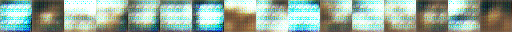

1 [3.3721159  0.27499348] 38.14609336853027


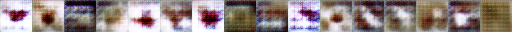

2 [3.1260703  0.29891482] 37.163296937942505


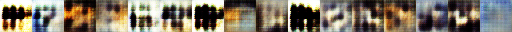

3 [3.1045537  0.33024013] 38.04267859458923


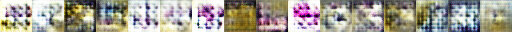

4 [3.1175017  0.35258475] 38.010162591934204


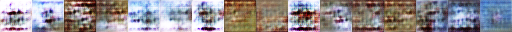

5 [3.007945   0.38591394] 38.118292808532715


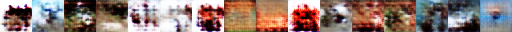

6 [3.1273627  0.31740612] 37.86123514175415


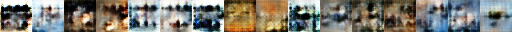

7 [3.4251301 0.273401 ] 37.76490545272827


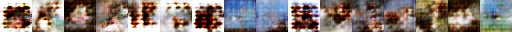

8 [3.6106467  0.25426483] 37.724101543426514


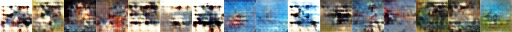

9 [3.9347444  0.20447339] 37.82199144363403


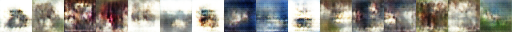

10 [3.9366632  0.21849433] 37.92930459976196


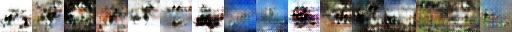

11 [3.7968378  0.24035424] 37.780738830566406


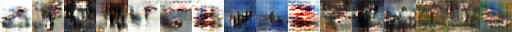

12 [3.7591052  0.27950785] 37.76277256011963


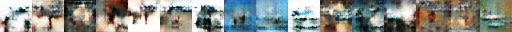

13 [3.4697325  0.27686748] 37.844178915023804


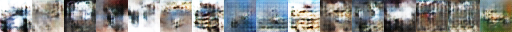

14 [3.458662   0.29977387] 37.7886381149292


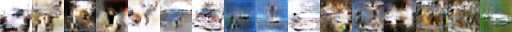

15 [3.1699278 0.3608542] 37.72336435317993


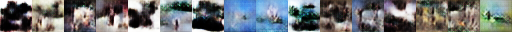

16 [3.0873504 0.3648657] 37.83320212364197


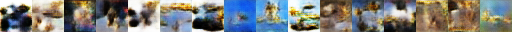

17 [2.996556   0.39420837] 37.84943675994873


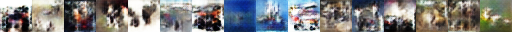

18 [2.8388624 0.4206632] 37.99649238586426


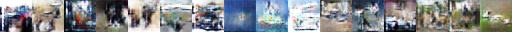

19 [2.6953208  0.44970828] 37.90512466430664


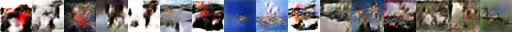

20 [2.651295   0.46393964] 37.89861345291138


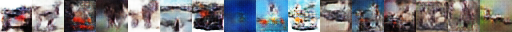

21 [2.5000846  0.50929767] 37.85677218437195


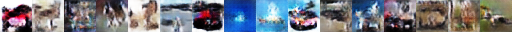

22 [2.430686   0.48370573] 37.82997131347656


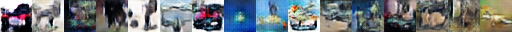

23 [2.5114732  0.51145905] 37.72144436836243


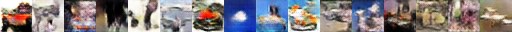

24 [2.3951757  0.52518594] 37.6375150680542


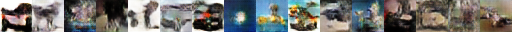

25 [2.384274  0.5051928] 37.67719101905823


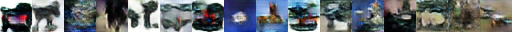

26 [2.33533    0.52694666] 37.90473294258118


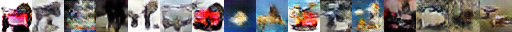

27 [2.3281088 0.516471 ] 37.94435095787048


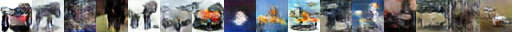

28 [2.3940525  0.51400983] 37.896390199661255


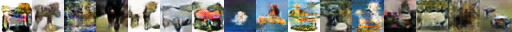

29 [2.4193256  0.49688494] 37.999064683914185


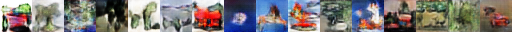

In [0]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  